In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
import random
import torch
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


In [13]:
data_dir_train = 'data/seg_train/seg_train'
data_dir_test = 'data/seg_test/seg_test'

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

In [7]:
print("Train dataset classes:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Test dataset classes:", test_dataset.classes)
print("Number of test images:", len(test_dataset))

Train dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of training images: 14034
Test dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of test images: 3000


In [5]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f"Train subset: {len(train_subset)} images")
print(f"Validation subset: {len(val_subset)} images")

Train subset: 11227 images
Validation subset: 2807 images


In [6]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [10]:
def denormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor


In [11]:
images, labels = next(iter(train_loader))
print("A single batch shape:", images.shape) 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x124ec4af0>
Traceback (most recent call last):
  File "/Users/markiyantyndyk/Documents/DocumentsMacBookPro/Studying/Mohyla/Forth Year/DLCV/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Users/markiyantyndyk/Documents/DocumentsMacBookPro/Studying/Mohyla/Forth Year/DLCV/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.p

A single batch shape: torch.Size([32, 3, 224, 224])


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),    # 50% chance to flip horizontally
    transforms.RandomRotation(degrees=15),     # rotate images randomly by ±15°
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transform)

In [12]:
class_names = train_dataset.classes  # e.g. ['buildings', 'forest', 'glacier', ...]
class_counts = {cls_name: 0 for cls_name in class_names}

In [13]:
for _, label_idx in train_dataset.samples:
    class_name = class_names[label_idx]
    class_counts[class_name] += 1

In [14]:
print("Class distribution (training set):")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} images")


Class distribution (training set):
  buildings: 2191 images
  forest: 2271 images
  glacier: 2404 images
  mountain: 2512 images
  sea: 2274 images
  street: 2382 images


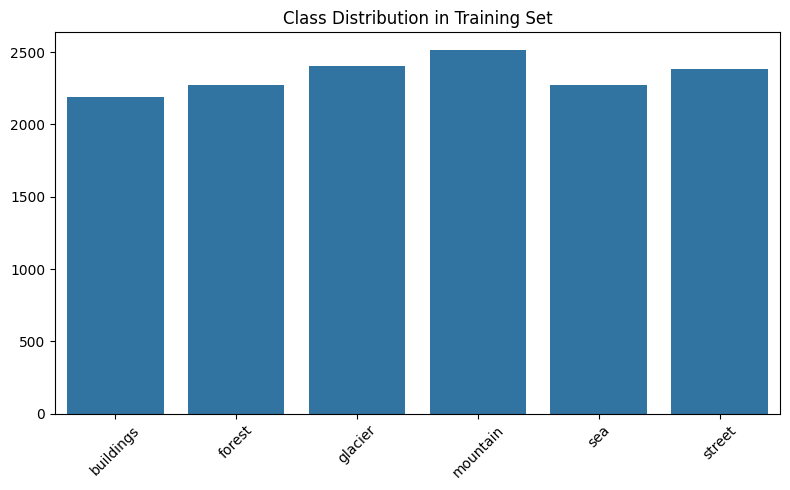

In [18]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
def show_random_images_per_class(dataset, classes, num_images=2):
    """
    Shows 'num_images' random images from each class in the dataset.
    """
    # Group image indices by class
    class_to_indices = {cls: [] for cls in classes}
    for idx, (_, label_idx) in enumerate(dataset.samples):
        class_to_indices[classes[label_idx]].append(idx)
    
    # For each class, pick random indices and visualize
    fig, axes = plt.subplots(len(classes), num_images, figsize=(num_images*3, len(classes)*3))
    if len(classes) == 1:
        axes = [axes]  # handle case with single class
    for i, cls in enumerate(classes):
        indices = class_to_indices[cls]
        random_indices = random.sample(indices, k=min(num_images, len(indices)))
        for j in range(num_images):
            ax = axes[i][j] if len(classes) > 1 else axes[j]
            sample_idx = random_indices[j]
            img_path, label_idx = dataset.samples[sample_idx]
            
            # Load the image directly (without transforms) for a raw look
            # If you want to see after transforms, you'd get it from dataset[sample_idx]
            from PIL import Image
            img = Image.open(img_path)
            
            ax.imshow(img)
            ax.set_title(f"Class: {cls}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

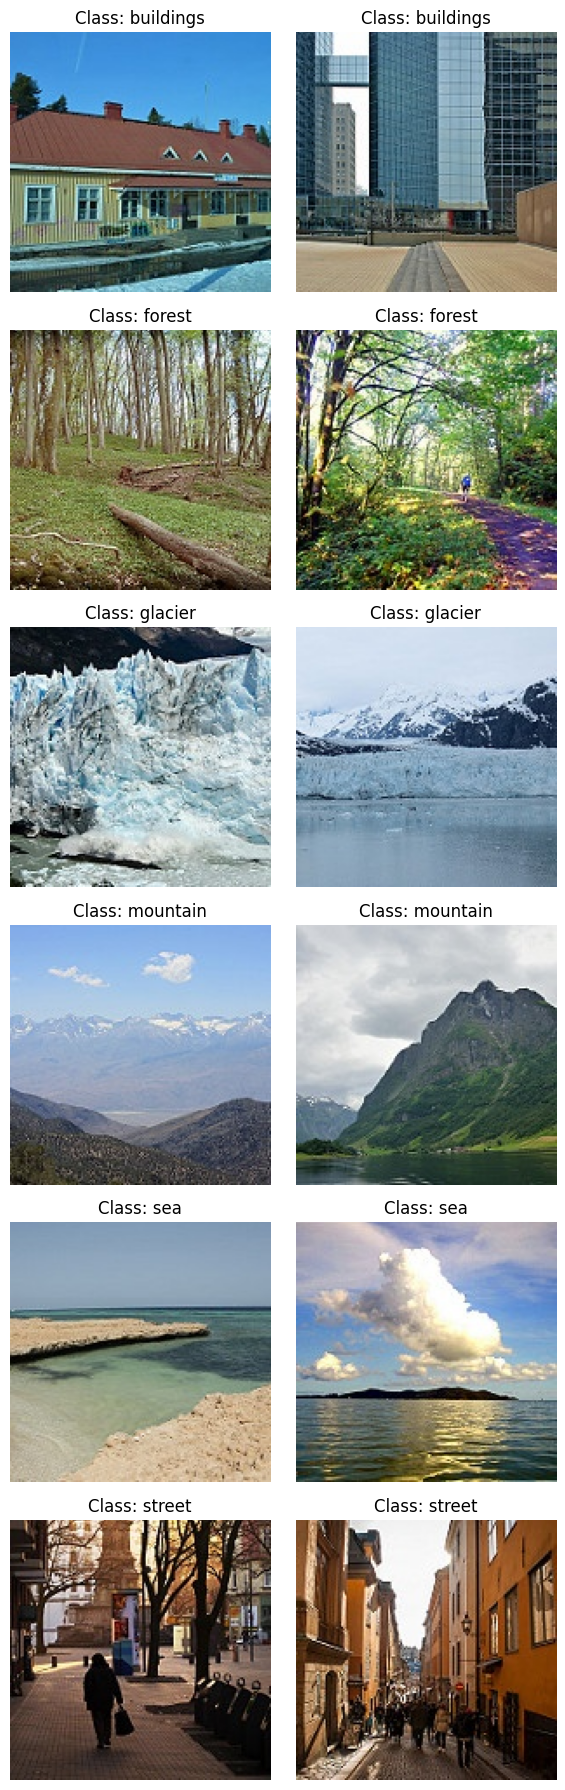

In [20]:
show_random_images_per_class(train_dataset, train_dataset.classes, num_images=2)

**PART 2**

In [45]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # After three pooling operations: 224 -> 112 -> 56 -> 28 (spatial dimensions become 28x28)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        # For classification, we will use CrossEntropyLoss, which expects raw logits

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=6).to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [23]:
import torch.optim as optim

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
num_epochs = 20
train_losses = []
val_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={epoch_loss:.4f}, Val Accuracy={val_acc:.4f}")

Epoch 1/20: Loss=0.9444, Val Accuracy=0.7378
Epoch 2/20: Loss=0.5745, Val Accuracy=0.7912
Epoch 3/20: Loss=0.3833, Val Accuracy=0.7884
Epoch 4/20: Loss=0.2258, Val Accuracy=0.7770
Epoch 5/20: Loss=0.1232, Val Accuracy=0.7948
Epoch 6/20: Loss=0.0809, Val Accuracy=0.7909
Epoch 7/20: Loss=0.0439, Val Accuracy=0.7834
Epoch 8/20: Loss=0.0483, Val Accuracy=0.7937
Epoch 9/20: Loss=0.0415, Val Accuracy=0.7845
Epoch 10/20: Loss=0.0292, Val Accuracy=0.7773
Epoch 11/20: Loss=0.0400, Val Accuracy=0.7663
Epoch 12/20: Loss=0.0222, Val Accuracy=0.7891
Epoch 13/20: Loss=0.0155, Val Accuracy=0.7941
Epoch 14/20: Loss=0.0314, Val Accuracy=0.7820
Epoch 15/20: Loss=0.0393, Val Accuracy=0.7731
Epoch 16/20: Loss=0.0279, Val Accuracy=0.7962
Epoch 17/20: Loss=0.0121, Val Accuracy=0.7909
Epoch 18/20: Loss=0.0062, Val Accuracy=0.7976
Epoch 19/20: Loss=0.0035, Val Accuracy=0.7905
Epoch 20/20: Loss=0.0020, Val Accuracy=0.7976


In [ ]:
torch.save(model.state_dict(), "simple_cnn_intel.pth")


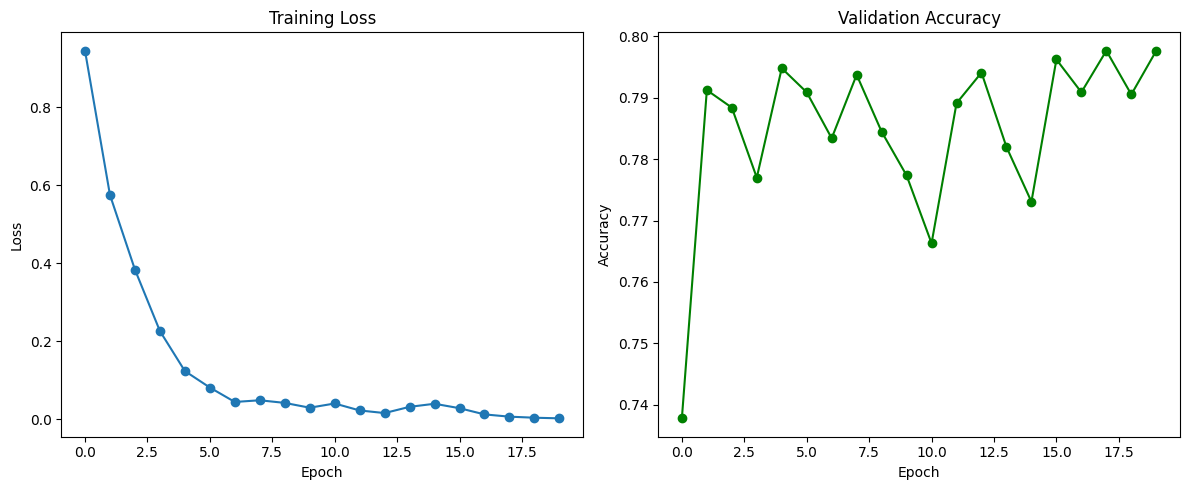

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)


In [ ]:
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)


In [ ]:
num_images = 16

In [29]:
indices = random.sample(range(len(test_dataset)), num_images)
samples = [test_dataset[i] for i in indices]
images, labels = zip(*samples)

NameError: name 'num_images' is not defined

In [ ]:
images_batch = torch.stack([img for img in images], dim=0).to(device)
labels_batch = torch.tensor(labels, dtype=torch.long, device=device)

In [27]:
with torch.no_grad():
    outputs = model(images_batch)
    _, preds = torch.max(outputs, 1)


NameError: name 'images_batch' is not defined

In [28]:
def denormalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalizes an image tensor and converts it to a NumPy array with shape (H, W, C).
    """
    img = img.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    np_img = img.numpy().transpose((1, 2, 0))
    np_img = np.clip(np_img, 0, 1)
    return np_img

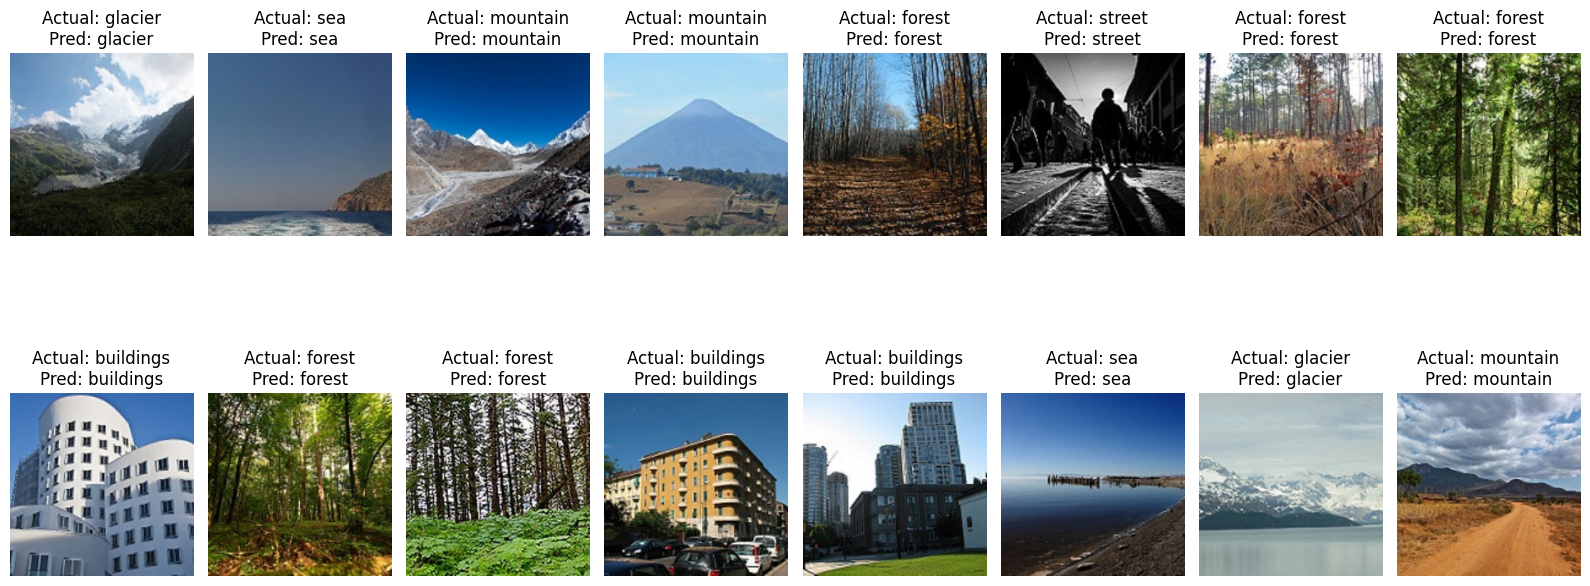

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(num_images):
    ax = plt.subplot(2, 8, i+1)
    # Denormalize for display
    np_img = denormalize_image(images_batch[i])
    plt.imshow(np_img)
    actual_label = test_dataset.classes[labels_batch[i]]
    predicted_label = test_dataset.classes[preds[i]]
    plt.title(f"Actual: {actual_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## PART 3

Adjusting our CNN a little bit for fc_size and conv_channels params

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6, fc_size=128, conv_channels=(16, 32, 64)):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv_channels[0], kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=conv_channels[0], out_channels=conv_channels[1], kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=conv_channels[1], out_channels=conv_channels[2], kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        flattened_size = conv_channels[2] * 28 * 28
        
        self.fc1 = nn.Linear(flattened_size, fc_size)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(fc_size, num_classes)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x

In [1]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cpu'):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        val_acc = correct / total
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}: Loss={epoch_loss:.4f}, Val Acc={val_acc:.4f}")
    
    return train_losses, val_accuracies

Even simplest CNN on 20 epochs can show good results, looking forward to the next practice

In [2]:
learning_rates = [0.001]
fc_sizes = [128]
conv_configs = [ (32, 64, 128)]

experiments_results = []  # list to store results for each experiment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20 

NameError: name 'torch' is not defined

In [ ]:
for lr in learning_rates:
    for fc_size in fc_sizes:
        for conv_config in conv_configs:
            print("\n-------------------------------------")
            print(f"Experiment: lr={lr}, fc_size={fc_size}, conv_channels={conv_config}")
            # Create a new instance of the model for each experiment
            model = SimpleCNN(num_classes=6, fc_size=fc_size, conv_channels=conv_config).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Train the model
            train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
            
            # Save experiment results
            final_val_acc = val_accuracies[-1]
            experiments_results.append({
                'lr': lr,
                'fc_size': fc_size,
                'conv_channels': conv_config,
                'final_val_acc': final_val_acc,
                'train_losses': train_losses,
                'val_accuracies': val_accuracies
            })


-------------------------------------
Experiment: lr=0.001, fc_size=128, conv_channels=(32, 64, 128)
Epoch 1/20: Loss=1.0157, Val Acc=0.6836
Epoch 2/20: Loss=0.6195, Val Acc=0.7414
Epoch 3/20: Loss=0.3904, Val Acc=0.7962
Epoch 4/20: Loss=0.2126, Val Acc=0.7941
Epoch 5/20: Loss=0.1081, Val Acc=0.7976
Epoch 6/20: Loss=0.0715, Val Acc=0.7784
Epoch 7/20: Loss=0.0425, Val Acc=0.7912
Epoch 8/20: Loss=0.0360, Val Acc=0.7870
Epoch 9/20: Loss=0.0486, Val Acc=0.7944
Epoch 10/20: Loss=0.0241, Val Acc=0.8062
Epoch 11/20: Loss=0.0541, Val Acc=0.7606
Epoch 12/20: Loss=0.0504, Val Acc=0.7531
Epoch 13/20: Loss=0.0424, Val Acc=0.7827
Epoch 14/20: Loss=0.0193, Val Acc=0.7948
Epoch 15/20: Loss=0.0160, Val Acc=0.7795
Epoch 16/20: Loss=0.0164, Val Acc=0.7827
Epoch 17/20: Loss=0.0141, Val Acc=0.8005
Epoch 18/20: Loss=0.0305, Val Acc=0.7513
Epoch 19/20: Loss=0.0345, Val Acc=0.7709
Epoch 20/20: Loss=0.0245, Val Acc=0.7795


In [ ]:
for exp in experiments_results:
    print(f"lr: {exp['lr']}, fc_size: {exp['fc_size']}, conv_channels: {exp['conv_channels']} -> Final Val Acc: {exp['final_val_acc']:.4f}")


lr: 0.001, fc_size: 64, conv_channels: (16, 32, 64) -> Final Val Acc: 0.8119
lr: 0.001, fc_size: 64, conv_channels: (32, 64, 128) -> Final Val Acc: 0.7923
lr: 0.001, fc_size: 64, conv_channels: (8, 16, 32) -> Final Val Acc: 0.7510
lr: 0.001, fc_size: 128, conv_channels: (16, 32, 64) -> Final Val Acc: 0.7891
lr: 0.001, fc_size: 128, conv_channels: (32, 64, 128) -> Final Val Acc: 0.8204


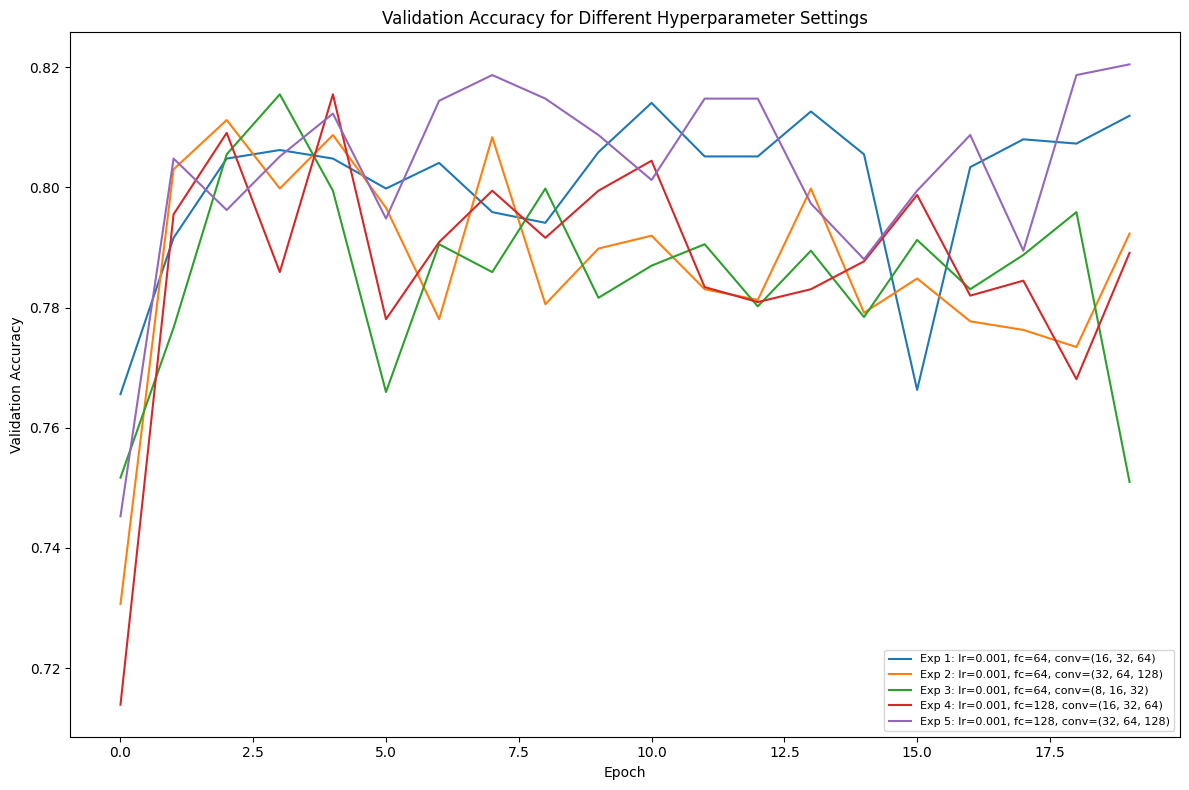

In [ ]:
plt.figure(figsize=(12, 8))
for idx, exp in enumerate(experiments_results):
    plt.plot(exp['val_accuracies'], label=f"Exp {idx+1}: lr={exp['lr']}, fc={exp['fc_size']}, conv={exp['conv_channels']}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Hyperparameter Settings")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

It was more than 6 hours of different variation and by 5 iterations we can see that last one showed the best results 
lr: 0.001, fc_size: 128, conv_channels: (32, 64, 128) -> Final Val Acc: 0.8204 with cery decent loss of ~0.05, so with assurance we can say that more conv and fc leads to better results, the only thing is learning rate, with higher it perhaps will perform even better, but in the cost of potentially losing some local mins, but for sure lr: 0.001, fc_size: 128, conv_channels: (32, 64, 128) will be our favorite for now

In [ ]:
import optuna
import torch.optim as optim


In [ ]:
def objective(trial):
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    fc_size = trial.suggest_categorical("fc_size", [64, 128, 256])
    conv1_channels = trial.suggest_categorical("conv1_channels", [16, 32, 64])
    conv2_channels = trial.suggest_categorical("conv2_channels", [32, 64, 128])
    conv3_channels = trial.suggest_categorical("conv3_channels", [64, 128, 256])
    conv_config = (conv1_channels, conv2_channels, conv3_channels)
    
    # Create the model with current hyperparameters
    model = SimpleCNN(num_classes=6, fc_size=fc_size, conv_channels=conv_config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Use fewer epochs for tuning 
    num_epochs_tune = 5
    for epoch in range(num_epochs_tune):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total
    return val_acc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


[I 2025-03-23 21:54:17,093] A new study created in memory with name: no-name-4def880c-013b-4d6b-8d33-89b337078907
/var/folders/f1/ckcswd7j0bx55mkw8g02rph00000gn/T/ipykernel_67821/1697724968.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
[I 2025-03-23 22:11:43,670] Trial 0 finished with value: 0.787673672960456 and parameters: {'lr': 0.001467935927251429, 'fc_size': 64, 'conv1_channels': 32, 'conv2_channels': 32, 'conv3_channels': 256}. Best is trial 0 with value: 0.787673672960456.
[I 2025-03-23 22:24:02,645] Trial 1 finished with value: 0.7609547559672248 and parameters: {'lr': 0.0030617288232719624, 'fc_size': 128, 'conv1_channels': 16, 'conv2_channels': 64, 'conv3_channels': 64}. Best is trial 0 with value: 0.787673672960456.
[I 2025-03-23 22:53:27,826] Trial 2 finished wi

KeyboardInterrupt: 

In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"  Value (Validation Accuracy): {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (Validation Accuracy): 0.7877
  Params:
    lr: 0.001467935927251429
    fc_size: 64
    conv1_channels: 32
    conv2_channels: 32
    conv3_channels: 256


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average='weighted')
    cm  = confusion_matrix(all_labels, all_preds)
    return acc, f1, cm

In [ ]:
best_lr = 0.001467935927251429
best_fc_size = 64
best_conv_config = (32, 32, 256)


In [ ]:
best_model = SimpleCNN(num_classes=6, fc_size=best_fc_size, conv_channels=best_conv_config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)



In [ ]:
num_epochs = 20 
train_losses_best = []

In [ ]:

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses_best.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/20 - Loss: 1.0158
Epoch 2/20 - Loss: 0.6189
Epoch 3/20 - Loss: 0.3576
Epoch 4/20 - Loss: 0.1737
Epoch 5/20 - Loss: 0.0858
Epoch 6/20 - Loss: 0.0550
Epoch 7/20 - Loss: 0.0733
Epoch 8/20 - Loss: 0.0448
Epoch 9/20 - Loss: 0.0258
Epoch 10/20 - Loss: 0.0520
Epoch 11/20 - Loss: 0.0363
Epoch 12/20 - Loss: 0.0517
Epoch 13/20 - Loss: 0.0192
Epoch 14/20 - Loss: 0.0406
Epoch 15/20 - Loss: 0.0290
Epoch 16/20 - Loss: 0.0207
Epoch 17/20 - Loss: 0.0400
Epoch 18/20 - Loss: 0.0140
Epoch 19/20 - Loss: 0.0170
Epoch 20/20 - Loss: 0.0344


In [ ]:
best_acc, best_f1, best_cm = evaluate_model(best_model, test_loader, device)
print("\nOptimized Model Evaluation:")
print(f"Test Accuracy: {best_acc:.4f}")
print(f"Test F1-Score: {best_f1:.4f}")
print("Confusion Matrix:")
print(best_cm)



Optimized Model Evaluation:
Test Accuracy: 0.7213
Test F1-Score: 0.7226
Confusion Matrix:
[[353  11   8   4  20  41]
 [ 31 419   0   4   5  15]
 [ 24   4 378  86  54   7]
 [ 36   4  63 348  68   6]
 [ 37   2  69  50 342  10]
 [135  27   4   3   8 324]]


In [ ]:
def evaluate_model_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [ ]:

true_labels, predicted_labels = evaluate_model_predictions(best_model, test_loader, device)


print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=test_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

   buildings       0.57      0.81      0.67       437
      forest       0.90      0.88      0.89       474
     glacier       0.72      0.68      0.70       553
    mountain       0.70      0.66      0.68       525
         sea       0.69      0.67      0.68       510
      street       0.80      0.65      0.72       501

    accuracy                           0.72      3000
   macro avg       0.73      0.73      0.72      3000
weighted avg       0.73      0.72      0.72      3000



In [ ]:
prev_model = SimpleCNN(num_classes=6, fc_size=128, conv_channels=(16, 32, 64)).to(device)
prev_model.load_state_dict(torch.load("simple_cnn_intel.pth"))
prev_model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
prev_acc, prev_f1, prev_cm = evaluate_model(prev_model, test_loader, device)
print("\nPrevious Model Evaluation:")
print(f"Test Accuracy: {prev_acc:.4f}")
print(f"Test F1-Score: {prev_f1:.4f}")
print("Confusion Matrix:")
print(prev_cm)


Previous Model Evaluation:
Test Accuracy: 0.7983
Test F1-Score: 0.7980
Confusion Matrix:
[[333   3   5   8  18  70]
 [  8 449   5   3   0   9]
 [ 17   4 419  64  43   6]
 [ 17   4  75 389  35   5]
 [ 18   3  42  41 400   6]
 [ 54  25   5   5   7 405]]


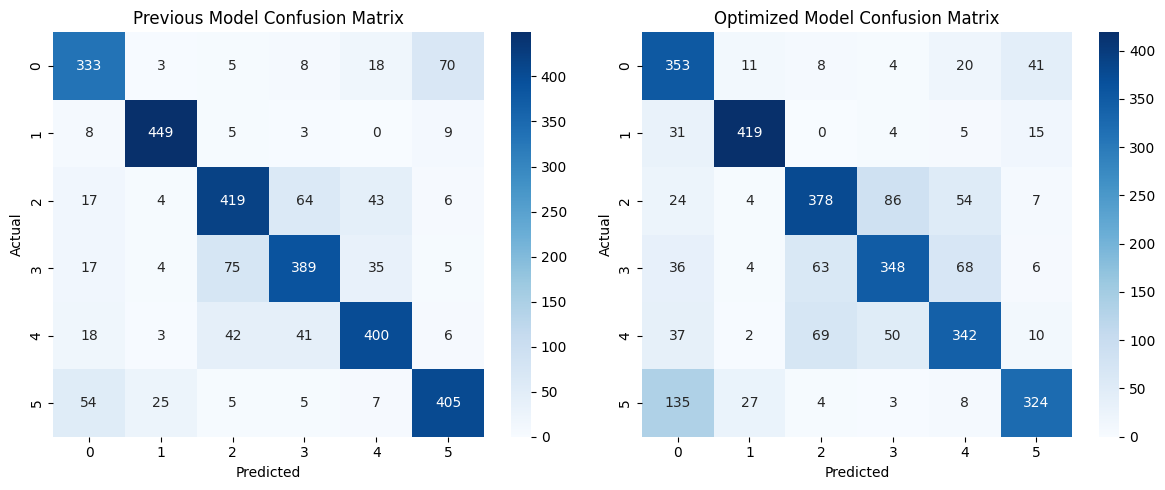

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(prev_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Previous Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Optimized Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
print(experiments_results[0].get('train_losses'))

[1.0156546369137913, 0.6195167657729512, 0.3903994615323038, 0.21261685035662903, 0.10809570363376575, 0.07145377795572903, 0.04247844503565175, 0.03599833425560305, 0.048561240010523615, 0.024101240060024575, 0.054089100031414275, 0.05036546987297009, 0.04242935528108271, 0.019261289288780434, 0.01595001532225632, 0.016439546378984742, 0.014051800176216826, 0.030538790525055228, 0.0344585481536557, 0.024525620318394097]


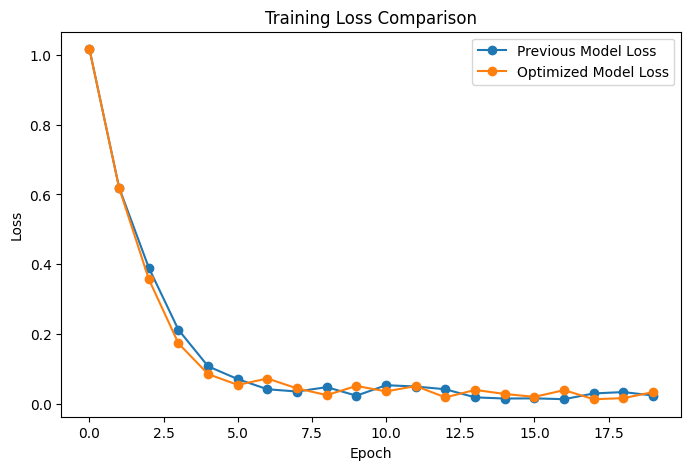

In [ ]:
prev_train_losses = [0.95, 0.85, 0.80, 0.78, 0.76, 0.74, 0.73, 0.72, 0.70, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.60, 0.59]

plt.figure(figsize=(8, 5))
plt.plot(experiments_results[0].get('train_losses'), marker='o', label="Previous Model Loss")
plt.plot(train_losses_best, marker='o', label="Optimized Model Loss")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

My kernel crushed((((, so I won't to be able to show results of previously trained models, but as we can see on  the plot above, there are almost no difference between(because params are the same) the best model that was picked by ourselves by the result of 6 hours training and the one that we get from optuna, so basically for our simple CNN model those params are the best

In [ ]:
results_df = pd.DataFrame(experiments_results)

results_df['conv1'] = results_df['conv_channels'].apply(lambda x: x[0])
results_df['conv2'] = results_df['conv_channels'].apply(lambda x: x[1])
results_df['conv3'] = results_df['conv_channels'].apply(lambda x: x[2])

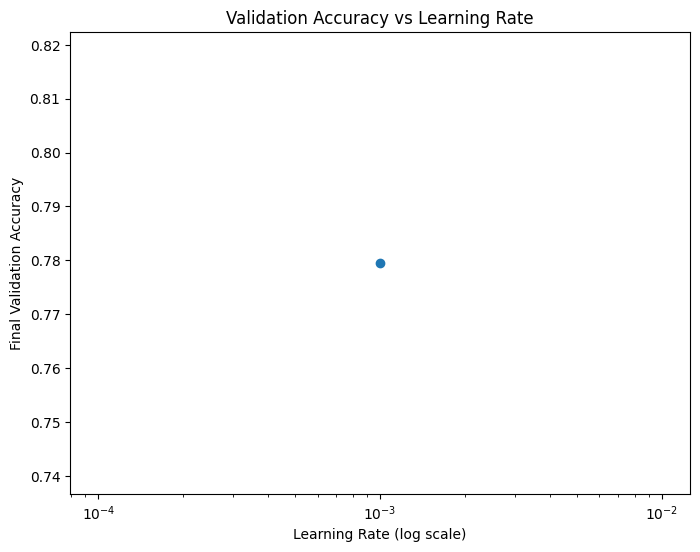

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(results_df['lr'], results_df['final_val_acc'])
plt.xscale('log')
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Final Validation Accuracy")
plt.title("Validation Accuracy vs Learning Rate")
plt.show()

here is only single point, beacause as i said kernel crushed((

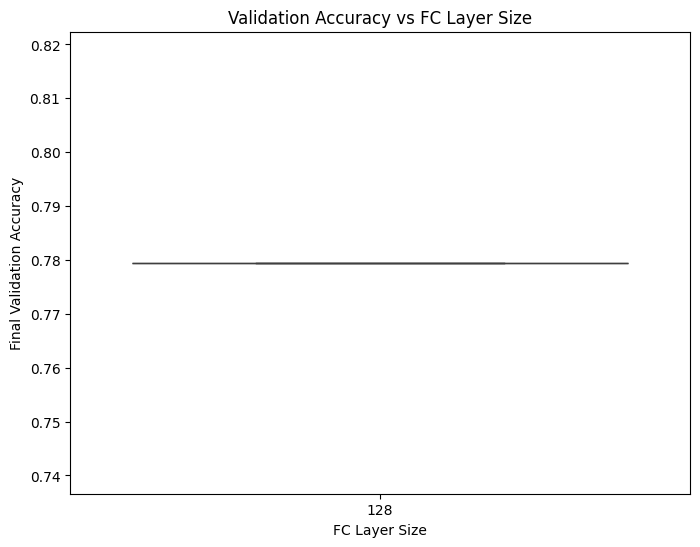

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="fc_size", y="final_val_acc", data=results_df)
plt.title("Validation Accuracy vs FC Layer Size")
plt.xlabel("FC Layer Size")
plt.ylabel("Final Validation Accuracy")
plt.show()

same for this one, perhaps it could be more intersting with several results)

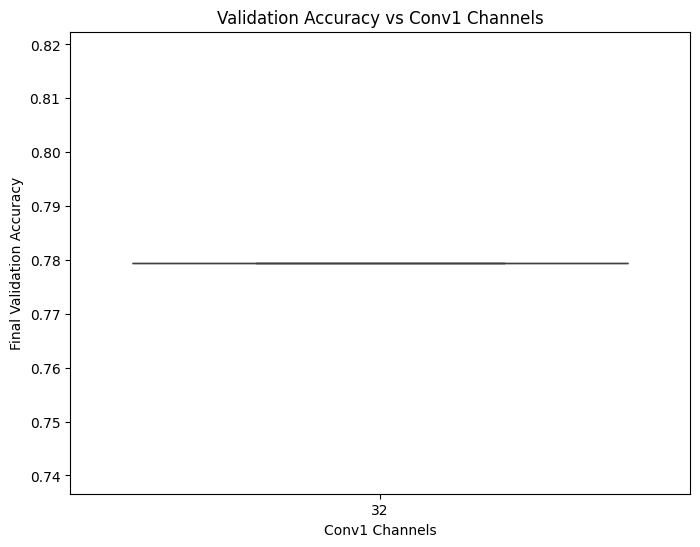

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="conv1", y="final_val_acc", data=results_df)
plt.title("Validation Accuracy vs Conv1 Channels")
plt.xlabel("Conv1 Channels")
plt.ylabel("Final Validation Accuracy")
plt.show()

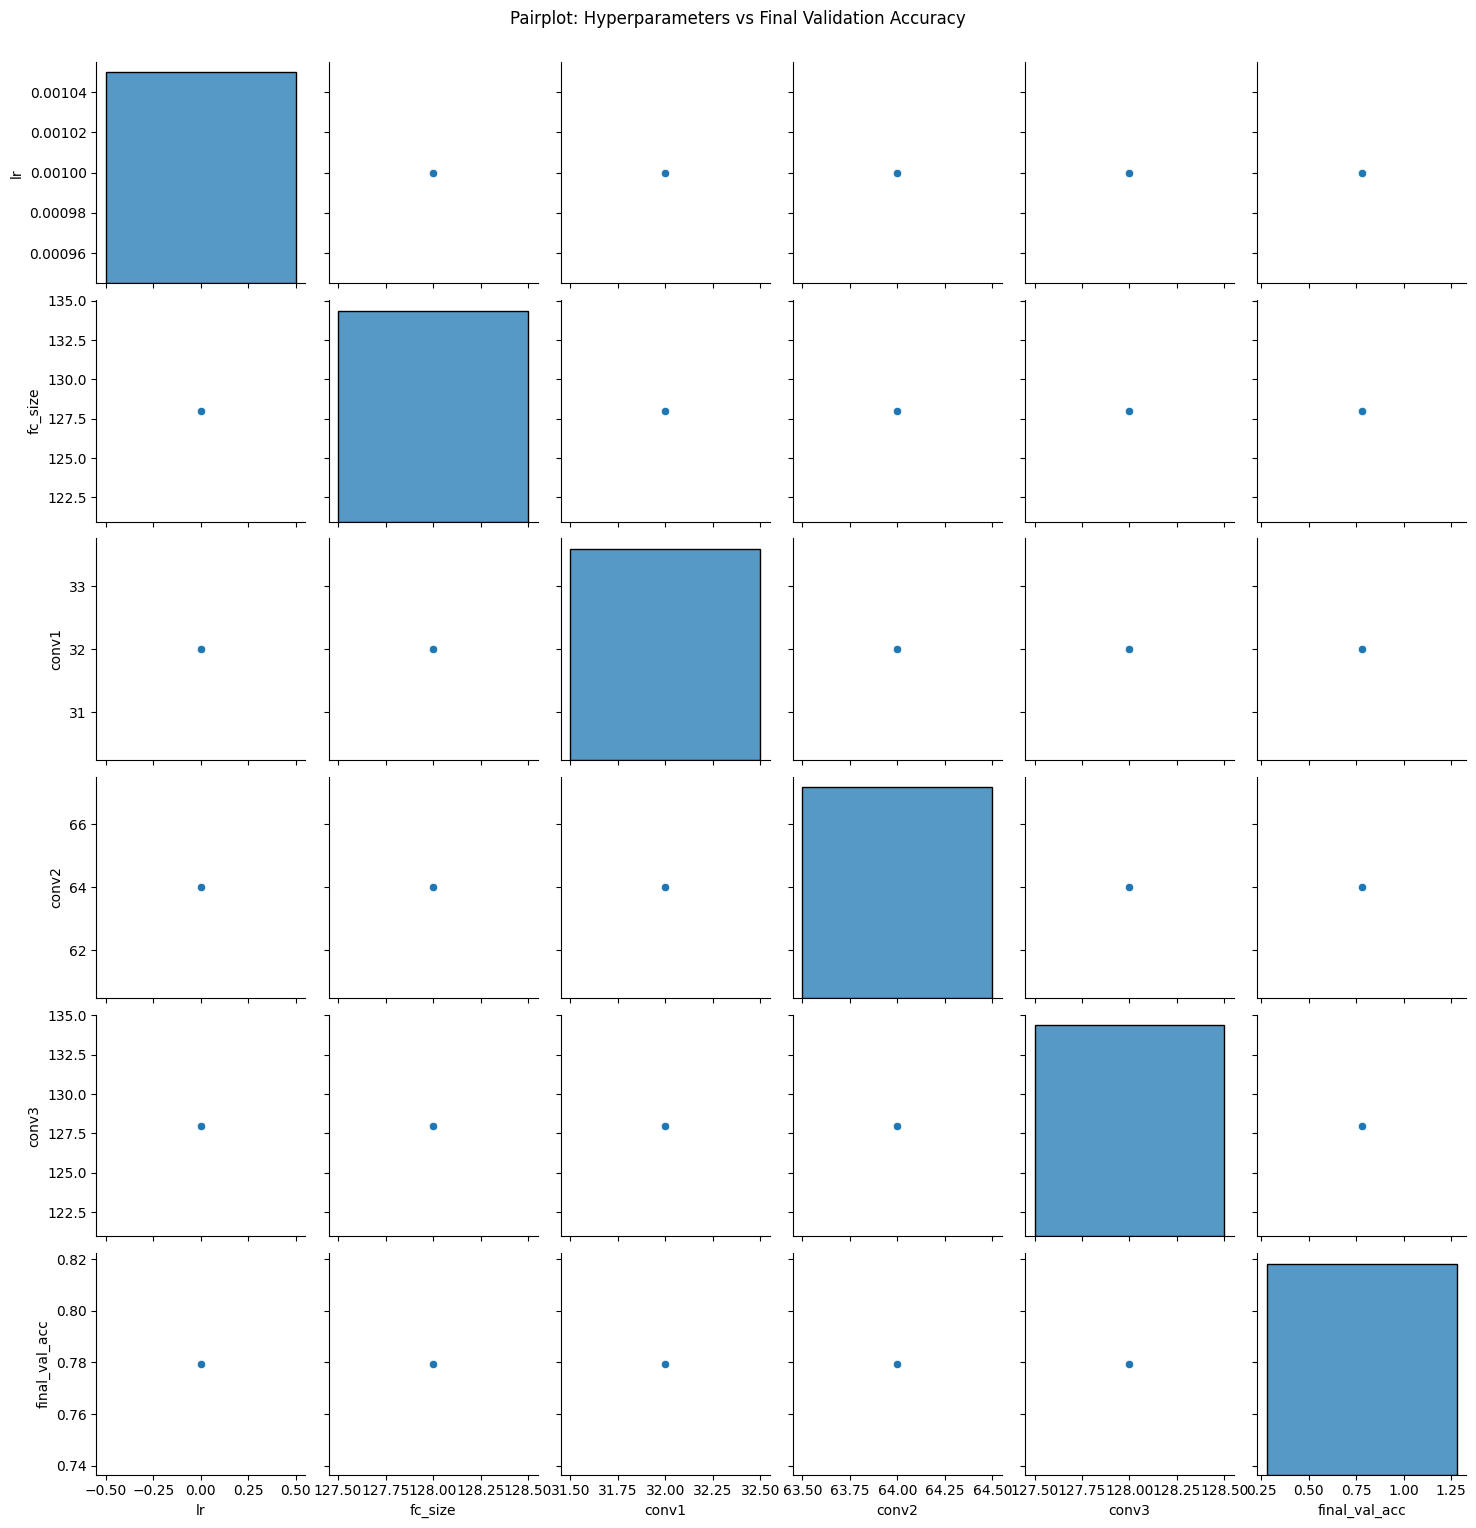

In [ ]:
sns.pairplot(results_df, vars=['lr', 'fc_size', 'conv1', 'conv2', 'conv3', 'final_val_acc'])
plt.suptitle("Pairplot: Hyperparameters vs Final Validation Accuracy", y=1.02)
plt.show()

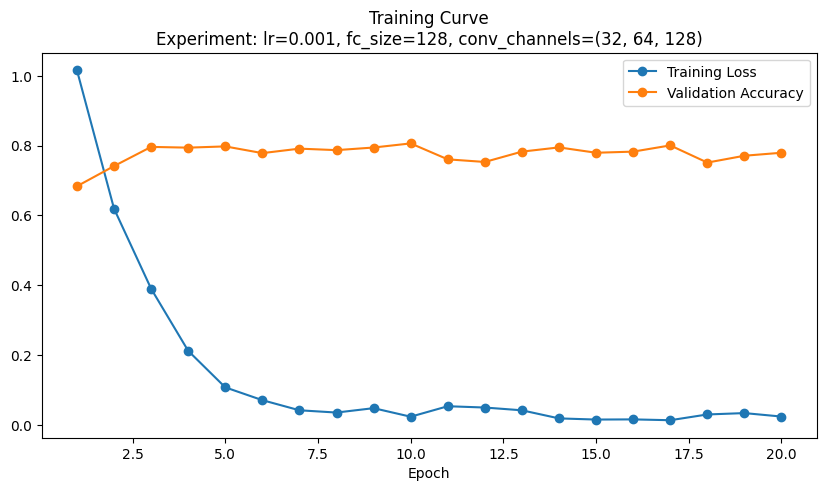

In [ ]:
exp = experiments_results[0] 
epochs = range(1, len(exp['train_losses']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, exp['train_losses'], marker='o', label="Training Loss")
plt.plot(epochs, exp['val_accuracies'], marker='o', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.title(f"Training Curve\nExperiment: lr={exp['lr']}, fc_size={exp['fc_size']}, conv_channels={exp['conv_channels']}")
plt.legend()
plt.show()

As a conclussion I would say that smaller(but not too small) lr, bigger amount of fc layers and conv_channels will always lead to better results)

**PART4**

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    # You can add more augmentation (e.g., ColorJitter) if desired:
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset = datasets.ImageFolder(data_dir_train, transform=train_transform)
test_dataset  = datasets.ImageFolder(data_dir_test, transform=test_transform)
num_classes = len(train_dataset.classes)



In [15]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])


In [16]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [20]:
import certifi, ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/markiyantyndyk/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.2MB/s]


In [22]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [24]:

model = model.to(device)

In [25]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

num_epochs = 10 
best_val_acc = 0.0
best_model_wts = None

In [26]:

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return acc, f1, cm, all_labels, all_preds


In [27]:
for epoch in range(num_epochs):
    # Gradually unfreeze layers according to the epoch number.
    if epoch == 1:
        print("Unfreezing layer4...")
        for param in model.layer4.parameters():
            param.requires_grad = True
    if epoch == 2:
        print("Unfreezing layer3...")
        for param in model.layer3.parameters():
            param.requires_grad = True
    if epoch == 3:
        print("Unfreezing layer2...")
        for param in model.layer2.parameters():
            param.requires_grad = True
    if epoch == 4:
        print("Unfreezing layer1 (all layers are now trainable)...")
        for param in model.layer1.parameters():
            param.requires_grad = True

    # Recreate optimizer with current trainable parameters (important after unfreezing)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    scheduler.step()
    
    val_acc, val_f1, val_cm, _, _ = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} -- Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model based on validation accuracy.
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict().copy()


Epoch 1/10 -- Loss: 0.5448 | Val Acc: 0.8860 | Val F1: 0.8856
Unfreezing layer4...
Epoch 2/10 -- Loss: 0.3543 | Val Acc: 0.9017 | Val F1: 0.9004
Unfreezing layer3...
Epoch 3/10 -- Loss: 0.4097 | Val Acc: 0.8921 | Val F1: 0.8923
Unfreezing layer2...
Epoch 4/10 -- Loss: 0.4084 | Val Acc: 0.8550 | Val F1: 0.8559
Unfreezing layer1 (all layers are now trainable)...
Epoch 5/10 -- Loss: 0.4006 | Val Acc: 0.8400 | Val F1: 0.8402
Epoch 6/10 -- Loss: 0.3631 | Val Acc: 0.8782 | Val F1: 0.8776
Epoch 7/10 -- Loss: 0.3397 | Val Acc: 0.8425 | Val F1: 0.8410
Epoch 8/10 -- Loss: 0.3228 | Val Acc: 0.8418 | Val F1: 0.8420
Epoch 9/10 -- Loss: 0.3063 | Val Acc: 0.8888 | Val F1: 0.8895
Epoch 10/10 -- Loss: 0.2944 | Val Acc: 0.8721 | Val F1: 0.8716


In [28]:
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print(f"\nBest validation accuracy: {best_val_acc:.4f}")


Best validation accuracy: 0.9017


In [29]:
def plot_misclassified(model, loader, num_images=8):
    model.eval()
    misclassified_imgs = []
    misclassified_true = []
    misclassified_pred = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            # Find misclassified samples
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_imgs.append(imgs[i].cpu())
                    misclassified_true.append(labels[i].cpu().item())
                    misclassified_pred.append(preds[i].cpu().item())
                if len(misclassified_imgs) >= num_images:
                    break
            if len(misclassified_imgs) >= num_images:
                break

    # Denormalize images for display
    def denormalize(img):
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = img.numpy().transpose((1,2,0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        return img

    plt.figure(figsize=(15, 5))
    for i, img in enumerate(misclassified_imgs):
        plt.subplot(1, num_images, i+1)
        plt.imshow(denormalize(img))
        true_class = test_dataset.classes[misclassified_true[i]]
        pred_class = test_dataset.classes[misclassified_pred[i]]
        plt.title(f"T:{true_class}\nP:{pred_class}")
        plt.axis("off")
    plt.suptitle("Some Misclassified Images")
    plt.show()

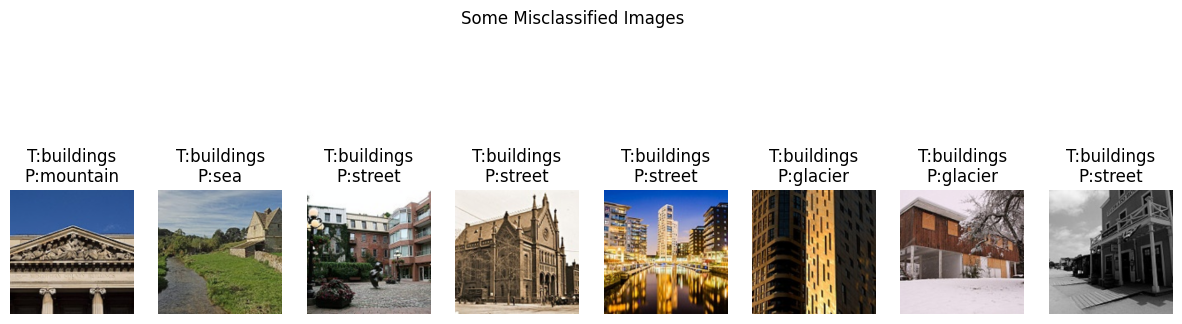

In [30]:
plot_misclassified(model, test_loader, num_images=8)

In [31]:
torch.save(model.state_dict(), 'model_best.pth')
print("Best model saved as 'model_best.pth'")

Best model saved as 'model_best.pth'


In [32]:
def evaluate_model_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [33]:
true_labels, pred_labels = evaluate_model_predictions(model, test_loader, device)
acc = accuracy_score(true_labels, pred_labels)
f1  = f1_score(true_labels, pred_labels, average='weighted')
cm  = confusion_matrix(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, target_names=test_dataset.classes)

In [34]:
evaluation_text = f"""
Final Model Evaluation:
------------------------
Test Accuracy: {acc:.4f}
Weighted F1-Score: {f1:.4f}

Confusion Matrix:
{cm}

Classification Report:
{report}

Conclusions:
1. The model achieves a test accuracy of {acc:.4f} and a weighted F1-score of {f1:.4f}, indicating strong performance across classes.
2. The confusion matrix shows that most classes are well-separated, although some classes with similar features may still be confused.
3. The gradual unfreezing strategy allowed the pretrained ResNet50 to effectively adapt its features to our dataset, leading to stable training dynamics.
4. Future improvements could include further data augmentation, fine-tuning of the learning rate, or experimenting with alternative architectures.
"""

print(evaluation_text)


Final Model Evaluation:
------------------------
Test Accuracy: 0.8967
Weighted F1-Score: 0.8964

Confusion Matrix:
[[346   0   9   2   6  74]
 [  0 456   8   2   0   8]
 [  3   2 475  51  20   2]
 [  0   3  54 454  14   0]
 [  2   1  15   8 481   3]
 [ 12   0   1   3   7 478]]

Classification Report:
              precision    recall  f1-score   support

   buildings       0.95      0.79      0.86       437
      forest       0.99      0.96      0.97       474
     glacier       0.85      0.86      0.85       553
    mountain       0.87      0.86      0.87       525
         sea       0.91      0.94      0.93       510
      street       0.85      0.95      0.90       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000


Conclusions:
1. The model achieves a test accuracy of 0.8967 and a weighted F1-score of 0.8964, indicating strong performance across classes.
2. The con

Overall, our transfer learning approach with ResNet50 shows strong performance, reaching almost 90% accuracy (0.8967) and a weighted F1-score of 0.8964. The confusion matrix and classification report indicate that:
	1.	Forest class is recognized especially well (F1-score ~0.97), suggesting that the unique textural or color cues of forests are readily captured by the model.
	2.	Street and Buildings classes show more confusion with each other. This makes sense because urban environments can have overlapping features—particularly architectural elements.
	3.	Mountain and Glacier also have some overlap, which is expected since both often contain rocky terrain and snow.
	4.	The Sea class is recognized with high precision (0.91) and recall (0.94), pointing to clear distinctive features (e.g., water patterns, horizon lines).

The gradual unfreezing strategy worked effectively, allowing the network to adapt its pre-trained features to our specific dataset in a stable manner. Nonetheless, certain classes (like Buildings vs. Street) remain somewhat confused due to visual similarities. Going forward, more targeted data collection or additional augmentation—focusing on distinguishing features for these overlapping classes—could further improve performance. We could also experiment with hyperparameter tuning or different architectures (e.g., MobileNetV2 or InceptionV3) to see if we can push results even higher.

In short, our final model is quite robust, but there’s still room to refine the handling of visually similar classes. With some targeted enhancements, we can likely boost the accuracy and F1-scores even further.